In [114]:
import os
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [115]:
p = Path('Images/')

In [116]:
dirs = p.glob("*")

image_data = []
labels = []

labels_dict = {
    'Pikachu': 0,
    'Bulbasaur': 1,
    'Meowth': 2
}
label_2_pokemon = {
    0: 'Pikachu',
    1: 'Bulbasaur',
    2: 'Meowth'
}

for folder_path in dirs:
    label = str(folder_path).split('\\')[-1]
    print(label, end=" ")
    cnt = 0
    for image_path in folder_path.glob('*.jpg'):
        img = image.load_img(image_path, target_size=(40, 40))
        img_arr = image.img_to_array(img)
        image_data.append(img_arr)
        labels.append(labels_dict[label])
        cnt += 1
    print("contains images: ", cnt)

Bulbasaur contains images:  176
Meowth contains images:  70
Pikachu contains images:  199


In [117]:
X = np.asarray(image_data)
Y = np.asarray(labels)

In [118]:
print(X.shape)
print(Y.shape)

(445, 40, 40, 3)
(445,)


In [119]:
X = X.reshape((X.shape[0], -1))/255.0
print(X.shape)

(445, 4800)


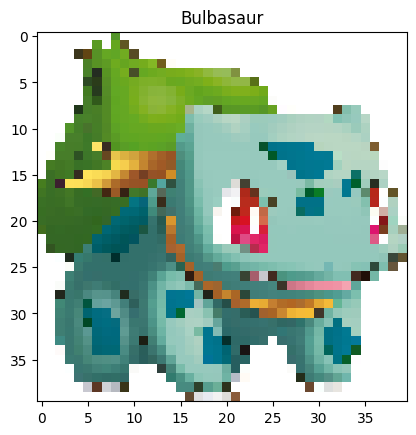

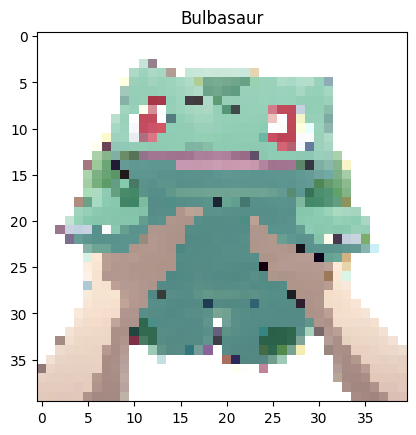

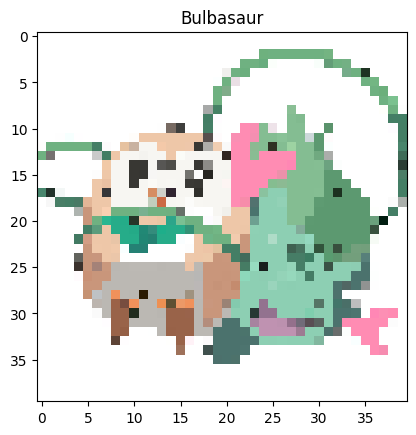

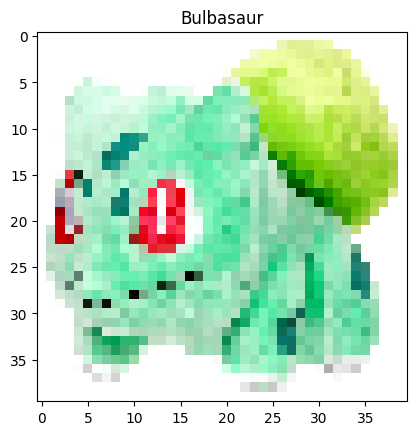

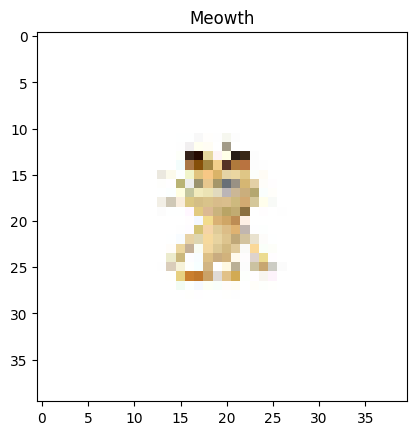

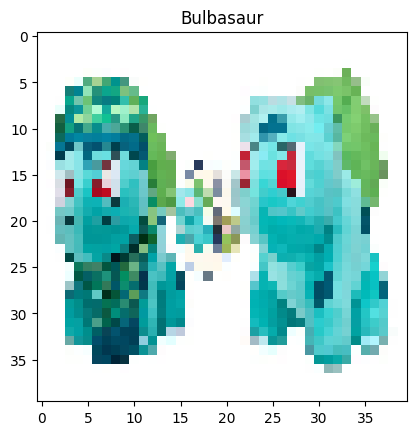

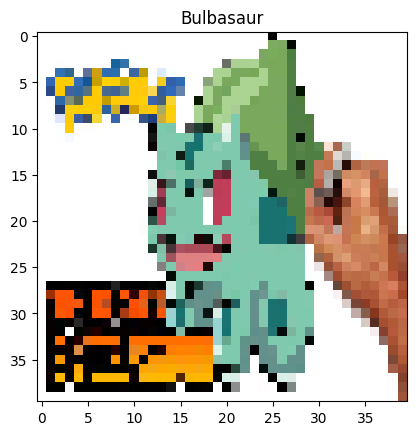

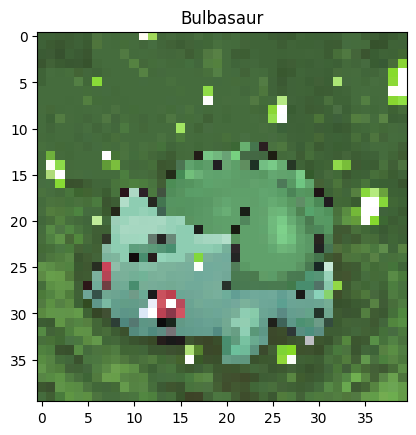

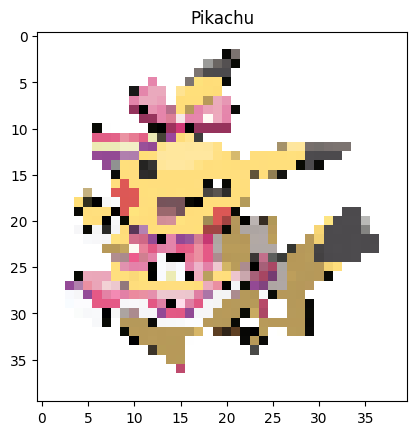

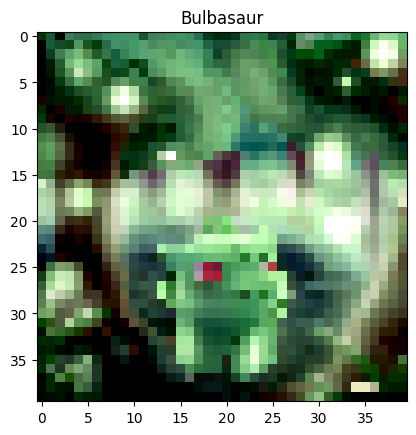

In [120]:
def drawImg(img, label, label2=-1):
    if label2 == -1:
        plt.title(label_2_pokemon[label])
    else:
        plt.title(label_2_pokemon[label] + " predicted as " + label_2_pokemon[label2])
    plt.imshow(img.reshape((40, 40, -1)))
    plt.show()

for i in range(10):
    index = np.random.randint(400)
    drawImg(X[index], Y[index])

In [121]:
from sklearn.utils import shuffle
X, Y = shuffle(X, Y, random_state=2)

In [122]:
from sklearn.model_selection import train_test_split

X, XTest, Y, YTest = train_test_split(X, Y, train_size=0.8, shuffle=True)

In [123]:
X.shape

(356, 4800)

In [124]:
XTest.shape

(89, 4800)

In [125]:
Y.shape

(356,)

In [126]:
def softmax(z):
    ep_a = np.exp(z)
    sp_a = np.sum(ep_a, axis=1, keepdims=True)
    return ep_a/(sp_a)
    
def loss(y_oht, p):
    l = -np.mean(y_oht*np.log(p))
    return l

def one_hot(y, category):
    m = y.shape[0]
    y_oht = np.zeros((m, category))
    y_oht[np.arange(m), y] = 1
    
    return y_oht


class NeuralNetwork:
    def __init__(self, input_size, layers, output_size):
        np.random.seed(0)
        
        self.input_size = input_size # no of features
        self.layers = layers # no of neurons in 1st and 2nd layer
        self.output_size = output_size
        model = {}
        
        # first layer
        model['w1'] = np.random.randn(input_size, layers[0])
        model['b1'] = np.zeros((1, layers[0]))
        
        # second layer
        model['w2'] = np.random.randn(layers[0], layers[1])
        model['b2'] = np.zeros((1, layers[1]))
        
        # output layer
        model['w3'] = np.random.randn(layers[1], output_size)
        model['b3'] = np.zeros((1, output_size))

        self.activation_outputs = 0
        self.model = model
        

    def forward(self, X):
        w1, w2, w3 = self.model['w1'], self.model['w2'], self.model['w3']
        b1, b2, b3 = self.model['b1'], self.model['b2'],  self.model['b3']
        
        z1 = np.dot(X, w1) + b1
        a1 = np.tanh(z1)

        z2 = np.dot(a1, w2) + b2
        a2 = np.tanh(z2)

        z3 = np.dot(a2, w3) + b3
        y_ = softmax(z3)

        self.activation_outputs = (a1, a2, y_)
        return y_
        

    def backward(self, x, y, learning_rate=0.001):
        w1, w2, w3 = self.model['w1'], self.model['w2'], self.model['w3']
        b1, b2, b3 = self.model['b1'], self.model['b2'], self.model['b3']
        m = x.shape[0]
        
        a1, a2, y_ = self.activation_outputs
        
        delta3 = y_ - y 
        dw3 = np.dot(a2.T, delta3)
        db3 = np.sum(delta3, axis=0)/float(m)
        
        delta2 = (1-np.square(a2)) * np.dot(delta3, w3.T) 
        dw2 = np.dot(a1.T, delta2)
        db2 = np.sum(delta2, axis=0)/float(m)

        delta1 = (1-np.square(a1)) * np.dot(delta2, w2.T)
        dw1 = np.dot(X.T, delta1)
        db1 = np.sum(delta1, axis=0)/float(m)

        # update the model parameters using Gradient Descent
        self.model['w1'] -= learning_rate * dw1
        self.model['b1'] -= learning_rate * db1
        
        self.model['w2'] -= learning_rate * dw2
        self.model['b2'] -= learning_rate * db2
        
        self.model['w3'] -= learning_rate * dw3
        self.model['b3'] -= learning_rate * db3


    def predict(self, x):
        y_out = self.forward(x)
        return np.argmax(y_out, axis=1)


    def summary(self):
        w1, w2, w3 = self.model['w1'], self.model['w2'], self.model['w3']
        a1, a2, y_ = self.activation_outputs

        print("w1: ", w1.shape)
        print("a1: ", a1.shape)
        
        print("w2: ", w2.shape)
        print("a2: ", a2.shape)
        
        print("w3: ", w3.shape)
        print("y_: ", y_.shape)     


def train(X, Y, model, epochs, alpha, logs=True):
    training_loss = []

    classes = len(np.unique(Y))
    y_oht = one_hot(Y, classes)

    for ix in range(epochs):
        Y_ = model.forward(X)
        l = loss(y_oht, Y_)
        training_loss.append(l)
        model.backward(X, y_oht, alpha)

        if logs and ix%50 == 0:
            print('Epoch %d loss %.4f'%(ix, l))

    return training_loss

In [127]:
model = NeuralNetwork(input_size=4800, layers=[100, 50], output_size=3)  # 4800 = (40x40x3) features

In [128]:
losses = train(X, Y, model=model, epochs=500, alpha=0.0002, logs=True)

Epoch 0 loss 3.2552
Epoch 50 loss 0.2694
Epoch 100 loss 0.1716
Epoch 150 loss 0.1064
Epoch 200 loss 0.0880
Epoch 250 loss 0.0758
Epoch 300 loss 0.0664
Epoch 350 loss 0.0578
Epoch 400 loss 0.0491
Epoch 450 loss 0.0435


In [129]:
XTest.shape

(89, 4800)

In [130]:
X.shape

(356, 4800)

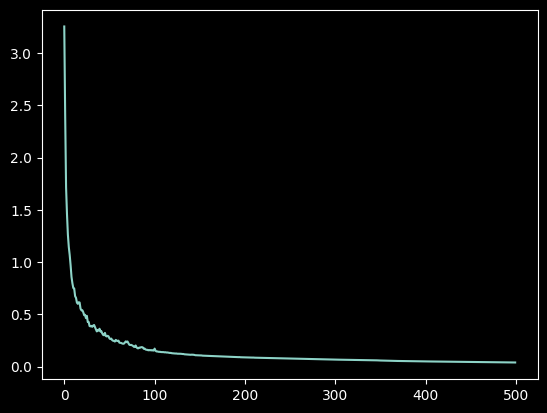

In [136]:
plt.style.use('dark_background')
plt.plot(losses)

In [137]:
def accuracy(X, Y, model):
    Ypred = model.predict(X)
    return np.sum(Ypred == Y)/Y.shape[0]

# Overfitting is Occuring below, because of... & how to overcome?
- Due to modelling with irrelevant pixels.
- Irrelevant features causing parametric changes to make curve overfitted
- Early stopping and Dropouts are two of many ways to make curve more generic.

In [138]:
accuracy(X, Y, model)

0.9747191011235955

In [139]:
accuracy(XTest, YTest, model)

0.550561797752809

In [140]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

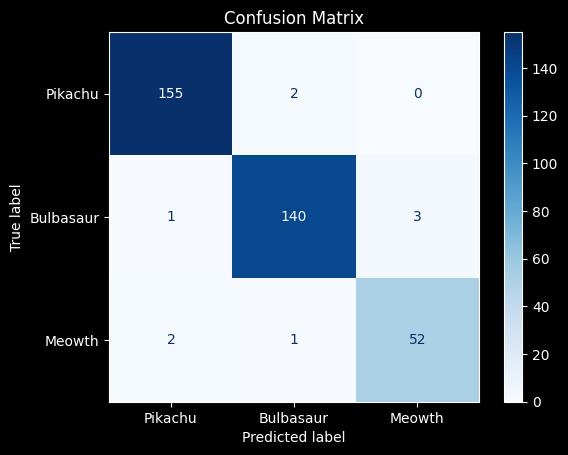

In [141]:
Ypred = model.predict(X)
cm = confusion_matrix(Y, Ypred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Pikachu", "Bulbasaur", "Meowth"])
disp.plot(cmap="Blues", values_format="d")
plt.title('Confusion Matrix')
plt.show()

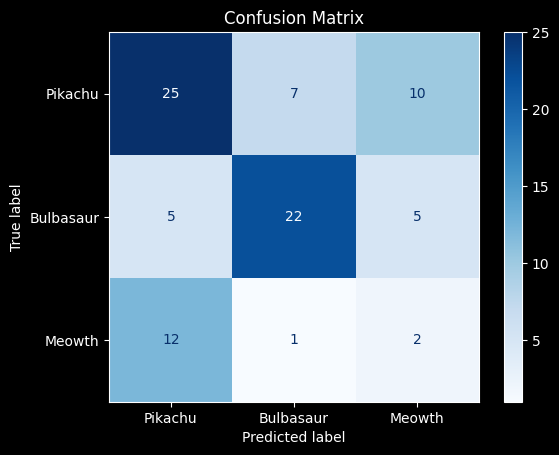

In [142]:
YpredTest = model.predict(XTest)
cm = confusion_matrix(YTest, YpredTest)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Pikachu", "Bulbasaur", "Meowth"])
disp.plot(cmap="Blues", values_format="d")
plt.title('Confusion Matrix')
plt.show()

In [143]:
from sklearn.metrics import classification_report

cr = classification_report(Y, Ypred)
print(cr)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       157
           1       0.98      0.97      0.98       144
           2       0.95      0.95      0.95        55

    accuracy                           0.97       356
   macro avg       0.97      0.97      0.97       356
weighted avg       0.97      0.97      0.97       356



In [144]:
cr = classification_report(YTest, YpredTest)
print(cr)

              precision    recall  f1-score   support

           0       0.60      0.60      0.60        42
           1       0.73      0.69      0.71        32
           2       0.12      0.13      0.12        15

    accuracy                           0.55        89
   macro avg       0.48      0.47      0.48        89
weighted avg       0.56      0.55      0.56        89



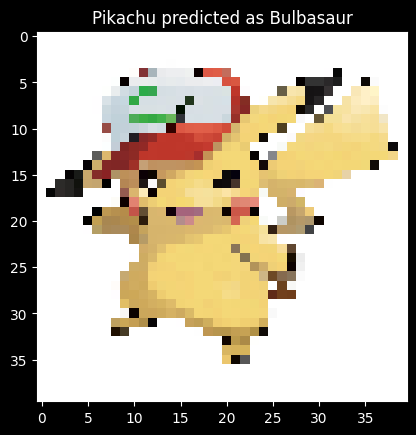

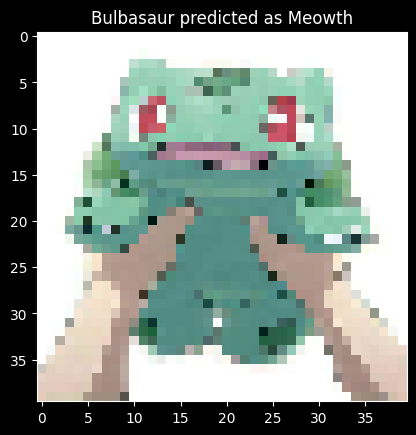

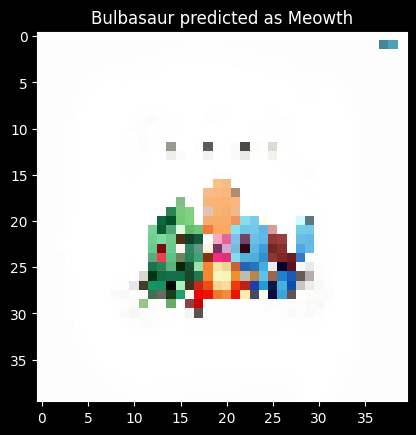

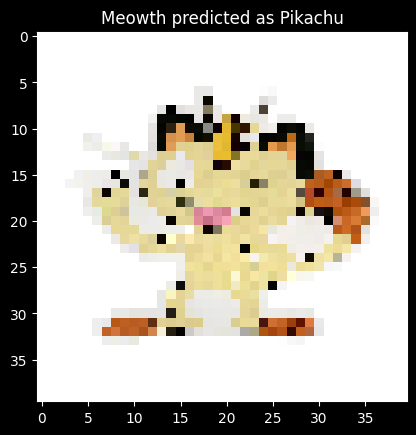

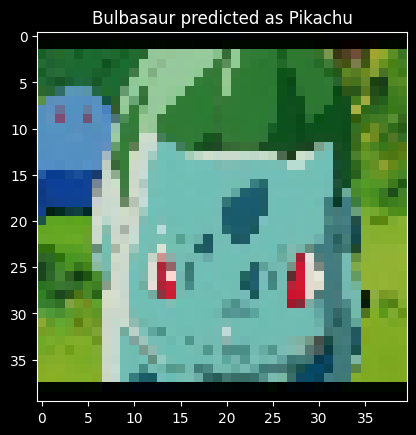

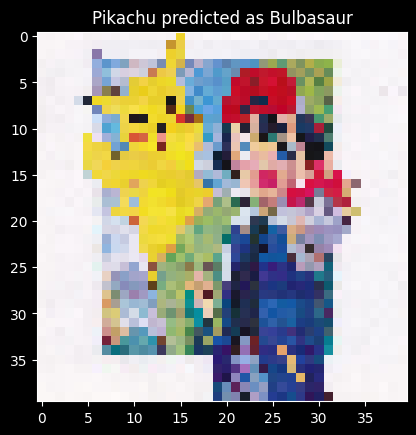

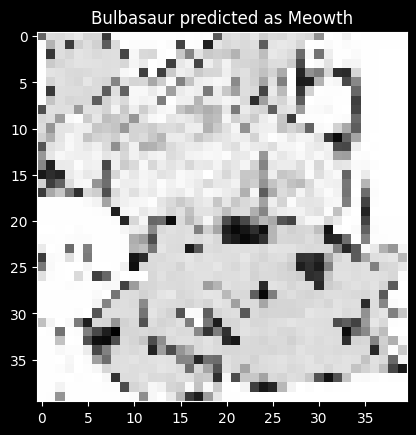

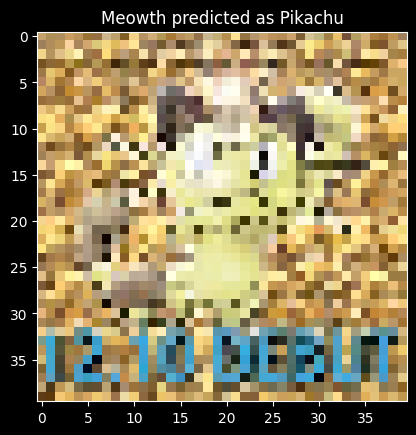

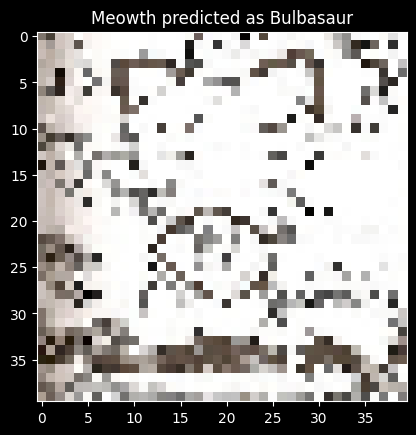

In [145]:
i = k = 0

while(k < min(np.sum(Y != Ypred), 10)):
    if Y[i] != Ypred[i]:
        drawImg(X[i], Y[i], Ypred[i])
        k += 1
    i += 1
        

# Using SKLEARN

In [146]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=150, activation='relu', alpha=0.0002)

In [147]:
mlp.fit(X, Y)

MLPClassifier(alpha=0.0002, hidden_layer_sizes=150)

In [148]:
mlp.score(X, Y)

1.0

In [149]:
mlp.score(XTest, YTest)

0.9101123595505618

## Activation function, Learning rate, Labels, Loss funtion, 

In [155]:
mlp.activation, mlp.alpha, mlp.classes_, mlp.loss

('relu', 0.0002, array([0, 1, 2]), 'log_loss')

## Loss curve MLP

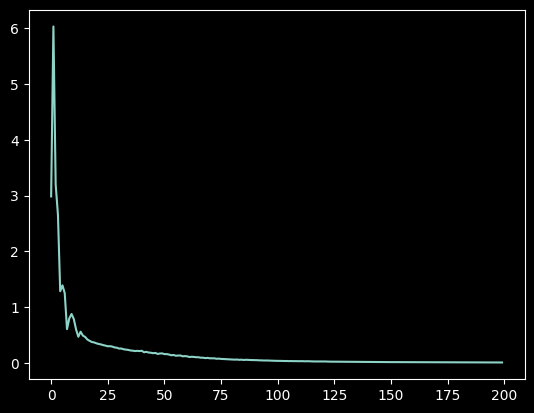

In [156]:
plt.plot(mlp.loss_curve_)

## Output neurons

In [157]:
mlp.n_layers_, mlp.n_outputs_

(3, 3)

## biases

In [158]:
len(mlp.intercepts_[0]), len(mlp.intercepts_[1])

(150, 3)